# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

An NOAA dataset has been stored in the file `data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`. The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Daily Global Historical Climatology Network](https://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe.

Each row in the assignment datafile corresponds to a single observation.

The following variables are provided to you:

* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write some python code which returns a line graph of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015.
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

The data you have been given is near **Ann Arbor, Michigan, United States**, and the stations the data comes from are shown on the map below.

In [1]:
# mplleaflet库可以根据经纬坐标，实现在地图上绘制点
import matplotlib.pyplot as plt
import mplleaflet
import pandas as pd
import numpy as np

def leaflet_plot_stations(binsize, hashid):

    df = pd.read_csv('data/C2A2_data/BinSize_d{}.csv'.format(binsize))

    station_locations_by_hash = df[df['hash'] == hashid]

    lons = station_locations_by_hash['LONGITUDE'].tolist()
    lats = station_locations_by_hash['LATITUDE'].tolist()

    plt.figure(figsize=(9,9))

    plt.scatter(lons, lats, c='r', alpha=0.7, s=200)

    return mplleaflet.display()

#leaflet_plot_stations(400,'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89')

### min_0514.groupby('Day').agg({'Data_Value': np.min})
### 利用Groupby和agg获得以Day为index的批量运算结果

In [2]:
df = pd.read_csv('data/C2A2_data/BinnedCsvs_d400/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df = df.sort_values(['Date'])

#利用 apply 和 lambda，批量取出Year 和 Day 属性
#利用Booling Map去除2-29信息
df['Year'] = df['Date'].apply(lambda x : x[:4])
df['Day'] = df['Date'].apply(lambda x : x[5:])
df = df[df['Day'] != '02-29']

#处理05-14年数据
min_0514 = df[df['Year'] != '2015']
min_0514 = min_0514[min_0514['Element'] == 'TMIN']
min_0514 = min_0514.groupby('Day').agg({'Data_Value': np.min})

max_0514 = df[df['Year'] != '2015']
max_0514 = max_0514[max_0514['Element'] == 'TMAX']
max_0514 = max_0514.groupby('Day').agg({'Data_Value': np.max})

#处理2015年数据
min2015 = df[df['Year'] == '2015']
min2015 = min2015[min2015['Element'] == 'TMIN']
min2015 = min2015.groupby('Day').agg({'Data_Value': np.min})

max2015 = df[df['Year'] == '2015']
max2015 = max2015[max2015['Element'] == 'TMAX']
max2015 = max2015.groupby('Day').agg({'Data_Value': np.max})

#Reset_Index()
min_0514.reset_index(inplace = True)
max_0514.reset_index(inplace = True)
min2015.reset_index(inplace = True)
max2015.reset_index(inplace = True)

#Broken Points
min_broken = pd.merge(min_0514,min2015, how = 'inner', left_on = 'Day', right_on = 'Day')
min_broken = min_broken[min_broken['Data_Value_x'] > min_broken['Data_Value_y']]
min_broken = min_broken[['Day','Data_Value_y']]
min_broken.rename(columns = {'Data_Value_y' : 'Data'}, inplace = True)

max_broken = pd.merge(max_0514,max2015, how = 'inner', left_on = 'Day', right_on = 'Day')
max_broken = max_broken[max_broken['Data_Value_y'] > max_broken['Data_Value_x']]
max_broken = max_broken[['Day','Data_Value_y']]
max_broken.rename(columns = {'Data_Value_y' : 'Data'}, inplace = True)

<IPython.core.display.Javascript object>


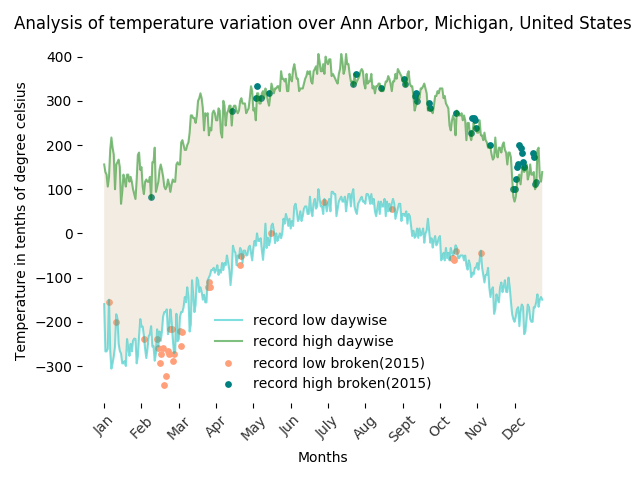

In [35]:
%matplotlib notebook
plt.figure()
#两个折线图
plt.plot(min_0514.index,min_0514['Data_Value'],'c',label = 'record low daywise',alpha = 0.5)
plt.plot(max_0514.index,max_0514['Data_Value'],'g',label = 'record high daywise', alpha = 0.5)

#两个散点图
plt.scatter(min_broken.index,min_broken['Data'],c = 'lightsalmon', s = 15, label = 'record low broken(2015)')
plt.scatter(max_broken.index,max_broken['Data'],c = 'teal', s = 15, label = 'record high broken(2015)')

#中间填充
plt.fill_between(min_0514.index,min_0514['Data_Value'],max_0514['Data_Value'],facecolor = 'tan',alpha = 0.25)

#图例，横坐标，标题等
plt.legend(frameon = False)
plt.xticks(range(0,365,31),['Jan','Feb','Mar','Apr','May','Jun','July','Aug','Sept','Oct','Nov','Dec'], rotation = 45, alpha=0.8)
plt.xlabel('Months')
plt.ylabel('Temperature in tenths of degree celsius')
plt.title('Analysis of temperature variation over Ann Arbor, Michigan, United States')
plt.tight_layout()

#去除边框
for spine in plt.gca().spines.values():
    spine.set_visible(False)
